In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

from typing import Text, Generator, Tuple, List, Optional, Dict, Set
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import json
import re
from tabulate import tabulate
sns.set_theme()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 5000)

C:\Users\kkolt\AppData\Local\Temp\ipykernel_44896\365501679.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
abs_path_data = '/SERGUI/data/'

# 0. Evaluation Metrics

In [3]:
from typing import Text, List, Callable, Dict, Optional, Tuple

class Metric(object):

    def __init__(self, func: Callable, name: Text):
        self.func = func
        self.name = name
    
    @staticmethod
    def binarize_annotations(annotations: List[int]) -> List[int]:
        return [1 if anno >= 2 else 0 for anno in annotations]

    @staticmethod
    def fill_results_zeros(annotations: List[int], k: int) -> List[int]:
        if len(annotations) >= k: return annotations
        else: return annotations + list(np.zeros((k - len(annotations)), dtype=int))

In [4]:
import numpy as np


def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item

    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).

    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75

    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])


def reciprocal_rank(r):
    # r is a binary array of relevance scores
    # computes the reciprocal rank for the given r
    non_zero = np.count_nonzero(r)
    if non_zero == 0:
        return 0
    return (1. / (np.asfarray(r).nonzero()[0][0] + 1))


def r_precision(r):
    """Score is precision after all relevant documents have been retrieved

    Relevance is binary (nonzero is relevant).

    >>> r = [0, 0, 1]
    >>> r_precision(r)
    0.33333333333333331
    >>> r = [0, 1, 0]
    >>> r_precision(r)
    0.5
    >>> r = [1, 0, 0]
    >>> r_precision(r)
    1.0

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        R Precision
    """
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])


def precision_at_k(r, k):
    """Score is precision @ k

    Relevance is binary (nonzero is relevant).

    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k


    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Precision @ k

    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    """Score is average precision (area under PR curve)

    Relevance is binary (nonzero is relevant).

    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    """Score is mean average precision

    Relevance is binary (nonzero is relevant).

    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666

    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])


def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)

    Relevance is positive real values.  Can use binary
    as the previous methods.

    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]

    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)

    Relevance is positive real values.  Can use binary
    as the previous methods.

    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]

    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

def hits_at_k(r, k):
    # r is a binary relevance array
    # k is the cutoff index
    # This metric returns 1 if there is at least one relevant item up to rank k else 0
    if len(r) == 0:
        return 0.
    r = np.asfarray(r)[:k]
    if np.sum(r) > 0:
        return 1.
    else:
        return 0.

In [5]:
    aveP = lambda annotations: average_precision(
        Metric.binarize_annotations(annotations))
    metricAveP = Metric(func=aveP, name='AveP')
    hitsAt1 = lambda annotations: hits_at_k(
        Metric.binarize_annotations(
        Metric.fill_results_zeros(annotations, 1)
        ), 1)
    metricHitsAt1 = Metric(func=hitsAt1, name='HITS@1')
    hitsAt2 = lambda annotations: hits_at_k(
        Metric.binarize_annotations(
        Metric.fill_results_zeros(annotations, 2)
        ), 2)
    metricHitsAt2 = Metric(func=hitsAt2, name='HITS@2')
    hitsAt3 = lambda annotations: hits_at_k(
        Metric.binarize_annotations(
        Metric.fill_results_zeros(annotations, 3)
        ), 3)
    metricHitsAt3 = Metric(func=hitsAt3, name='HITS@3')
    hitsAt5 = lambda annotations: hits_at_k(
        Metric.binarize_annotations(
        Metric.fill_results_zeros(annotations, 5)
        ), 5)
    metricHitsAt5 = Metric(func=hitsAt5, name='HITS@5')
    hitsAt7 = lambda annotations: hits_at_k(
        Metric.binarize_annotations(
            Metric.fill_results_zeros(annotations, 7)
        ), 7)
    metricHitsAt7 = Metric(func=hitsAt7, name='HITS@7')
    hitsAt10 = lambda annotations: hits_at_k(
        Metric.binarize_annotations(
        Metric.fill_results_zeros(annotations, 10)
        ), 10)
    metricHitsAt10 = Metric(func=hitsAt10, name='HITS@10')
    hitsAt15 = lambda annotations: hits_at_k(
        Metric.binarize_annotations(
        Metric.fill_results_zeros(annotations, 15)
        ), 15)
    metricHitsAt15 = Metric(func=hitsAt15, name='HITS@15')
    recipRank = lambda annotations: reciprocal_rank(
        Metric.binarize_annotations(
            Metric.fill_results_zeros(annotations, 15)
        ))
    metricRecipRank = Metric(func=recipRank, name='RecipRank')
    pAt1 = lambda annotations: precision_at_k(
        Metric.binarize_annotations(
            Metric.fill_results_zeros(annotations, 1)), 1)
    metricPAt1 = Metric(func=pAt1, name='P@1')
    pAt2 = lambda annotations: precision_at_k(
        Metric.binarize_annotations(
            Metric.fill_results_zeros(annotations, 2)
        ), 2)
    metricPAt2 = Metric(func=pAt2, name='P@2')
    pAt3 = lambda annotations: precision_at_k(
        Metric.binarize_annotations(
            Metric.fill_results_zeros(annotations, 3)
        ), 3)
    metricPAt3 = Metric(func=pAt3, name='P@3')
    pAt5 = lambda annotations: precision_at_k(
        Metric.binarize_annotations(
            Metric.fill_results_zeros(annotations, 5)
        ), 5)
    metricPAt5 = Metric(func=pAt5, name='P@5')
    pAt7 = lambda annotations: precision_at_k(
        Metric.binarize_annotations(
            Metric.fill_results_zeros(annotations, 7)
        ), 7)
    metricPAt7 = Metric(func=pAt7, name='P@7')
    pAt10 = lambda annotations: precision_at_k(
        Metric.binarize_annotations(
            Metric.fill_results_zeros(annotations, 10)
        ), 10)
    metricPAt10 = Metric(func=pAt10, name='P@10')
    pAt15 = lambda annotations: precision_at_k(
        Metric.binarize_annotations(
            Metric.fill_results_zeros(annotations, 15)
        ), 15)
    metricPAt15 = Metric(func=pAt15, name='P@15')

In [6]:
def print_table_report(relevance_groups, metrics, digits=3):
    header = ['group']
    header.extend([metric.name for metric in metrics])
    table = []
    for group_name, relevances in relevance_groups.iteritems():
        row = [group_name]
        for metric in metrics:
            metric_val = round(np.mean([metric.func(rels) for rels in relevances]), digits)
            metric_val = '.' + str(metric_val).split('.')[1]  if metric_val < 1.0 else '1.0'
            row.append('|'+str(metric_val))
        table.append(row)
    print(tabulate(tabular_data=table, headers=header))
    
def print_table_report_dict(relevance_groups, metrics, digits=3):
    header = ['group']
    header.extend([metric.name for metric in metrics])
    table = []
    for group_name, relevances in relevance_groups.items():
        row = [group_name]
        for metric in metrics:
            metric_val = round(np.mean([metric.func(rels) for rels in relevances]), digits)
            metric_val = '.' + str(metric_val).split('.')[1]  if metric_val < 1.0 else '1.0'
            row.append('|'+str(metric_val))
        table.append(row)
    print(tabulate(tabular_data=table, headers=header))

def print_table_report_simpl(relevances, metrics, name, digits=3):
    header = ['group']
    header.extend([metric.name for metric in metrics])
    table = []
    row = [name]
    for metric in metrics:
            metric_val = round(np.mean([metric.func(rels) for rels in relevances]), digits)
            metric_val = '.' + str(metric_val).split('.')[1]  if metric_val < 1.0 else '1.0'
            row.append('|'+str(metric_val))
    table.append(row)
    tabulated_table = tabulate(tabular_data=table, headers=header)
    print(tabulated_table)

# 1. Feature Recommendation Relevance Evaluation

In [7]:
feature_recommendation_relevance_annotations = pd.read_csv(abs_path_data+"/user_study/relevance/feature_recommended_relevance_annotation.csv")
feature_recommendation_relevance_annotations['ranking'] = feature_recommendation_relevance_annotations['ranking'].apply(literal_eval)
feature_recommendation_relevance_annotations['timestamp'] = pd.to_datetime(feature_recommendation_relevance_annotations['timestamp'])
feature_recommendation_relevance_annotations['feature_annotation_original'] =  feature_recommendation_relevance_annotations['feature_annotation']
feature_recommendation_relevance_annotations['feature_annotation'] =  feature_recommendation_relevance_annotations['feature_annotation'].apply(lambda x: 2 if x==1 else 0)

In [8]:
feature_recommendation_relevance_annotations = feature_recommendation_relevance_annotations.drop(columns='ranking')

In [9]:
feature_recommendation_relevance_annotations = feature_recommendation_relevance_annotations.sort_values('timestamp')

In [10]:
feature_recommendation_relevance_annotations[:3]

,user_id,gui_id,task_number,gui_number,nlr_query,feature_text,feature_question,timestamp,selected_gui_id,feature_annotation,matching_annotation,feature_annotation_original
0,774c7102-7340-4a69-bbdf-38e926fd3c98,ea391d5c-034c-4734-bf09-cee1c1c2f733,1,1,product page,product description,"Is a <b>'product description'</b> feature in the GUI a requirement for you? This feature provides a detailed description of the product, including its features, uses, and benefits.",2023-07-24 13:29:35,"""25967""",2,2,1
1,774c7102-7340-4a69-bbdf-38e926fd3c98,ea391d5c-034c-4734-bf09-cee1c1c2f733,1,1,product page,discounts,"Often similar GUIs contain a <b>'discounts'</b> feature, is it also required for your GUI? This feature displays any discounts or promotional offers available for the product.",2023-07-24 13:30:07,"""35152""",2,0,1
2,774c7102-7340-4a69-bbdf-38e926fd3c98,ea391d5c-034c-4734-bf09-cee1c1c2f733,1,1,product page,seller information,"Is a <b>'seller information'</b> feature relevant for your GUI? This feature provides information about the seller, including their name, rating, and other products they sell.",2023-07-24 13:30:34,NaN,0,-1,0


In [11]:
df_already_specified = feature_recommendation_relevance_annotations[feature_recommendation_relevance_annotations['feature_annotation_original']==3]

In [12]:
df_negative_feedback = feature_recommendation_relevance_annotations[(feature_recommendation_relevance_annotations['feature_annotation_original']==0) | (feature_recommendation_relevance_annotations['feature_annotation_original']==3)]

In [13]:
df_positive_feedback = feature_recommendation_relevance_annotations[feature_recommendation_relevance_annotations['feature_annotation_original']==1]

In [14]:
print('#Recommendations: {}'.format(len(feature_recommendation_relevance_annotations)))
print('#Pos-feedback: {}'.format(len(df_positive_feedback)))
print('#Neg-feedback: {}'.format(len(df_negative_feedback)))
print('#Alred-spec: {}'.format(len(df_already_specified)))
print('Accuracy: {}'.format(len(df_positive_feedback)/len(feature_recommendation_relevance_annotations)))
print('Perc.alredy-neg: {}'.format(len(df_already_specified)/len(df_negative_feedback)))

#Recommendations: 720
#Pos-feedback: 459
#Neg-feedback: 261
#Alred-spec: 68
Accuracy: 0.6375
Perc.alredy-neg: 0.26053639846743293


In [15]:
grouped_df = feature_recommendation_relevance_annotations.groupby(['gui_id']).agg({'feature_annotation': list})
grouped_df = grouped_df.reset_index()
grouped_df[:10]

,gui_id,feature_annotation
0,00cbdd5f-a63b-4bb6-a3e0-c64e730e0821,"[2, 0, 2, 2, 0, 2, 0, 0, 0, 2]"
1,0b8b88e3-3a12-4f9d-b13b-1bce6fd58e35,"[2, 2, 2, 2, 2, 0, 2, 2, 0, 0]"
2,0e0fee74-9017-43f5-bcf2-6b5679c8b954,"[2, 0, 2, 0, 2, 2, 0, 2, 2, 0]"
3,10e34a88-584d-44ed-8507-25caa1a15fff,"[2, 0, 2, 2, 0, 2, 2, 0, 2, 0]"
4,117a851a-d372-4345-93d1-173083e5c263,"[2, 2, 0, 0, 2, 2, 2, 0, 2, 2]"
5,134ed8aa-026e-4177-9c3c-77b122a0082b,"[2, 2, 0, 2, 0, 2, 2, 2, 2, 0]"
6,1385d42b-2190-4d14-8903-a64d4c2c3a39,"[0, 0, 2, 0, 0, 0, 0, 0, 2, 0]"
7,1581d817-53e0-4015-ba02-5b16f47f1d2d,"[2, 0, 2, 2, 0, 0, 2, 2, 2, 2]"
8,15a0e403-e906-4a77-8c53-9655eedbe25c,"[0, 2, 2, 0, 0, 0, 0, 0, 0, 0]"
9,16120257-80e3-4e78-9f2c-af3d71dd5fea,"[0, 2, 2, 2, 2, 0, 2, 2, 0, 0]"


In [16]:
data_dict = {}
for index, row in feature_recommendation_relevance_annotations.iterrows():
    gui_id = row['gui_id']
    task_number = row['task_number']
    gui_number = row['gui_number']
    data_dict[gui_id] = (task_number, gui_number)

In [17]:
feature_recommendations_per_gui_task = pd.DataFrame.from_dict(data_dict, orient='index', columns=['task_number', 'gui_number'])
feature_recommendations_per_gui_task = feature_recommendations_per_gui_task.reset_index()
feature_recommendations_per_gui_task = feature_recommendations_per_gui_task.rename(columns={'index': 'gui_id'})
feature_recommendations_per_gui_task[:10]

,gui_id,task_number,gui_number
0,ea391d5c-034c-4734-bf09-cee1c1c2f733,1,1
1,117a851a-d372-4345-93d1-173083e5c263,1,2
2,1eacb360-90eb-4276-a4e0-28330d020e73,1,3
3,bdaf422d-d721-44e4-8c80-eb404426171a,3,1
4,828e5bc1-dbf9-47a1-a7c0-919f7eaf95ae,3,2
5,6031ec72-b73c-4399-a614-a875b6d04dff,3,3
6,5c63126c-d909-4531-8672-2cd06d743964,2,1
7,eb476d80-e1c7-467b-82fb-98457aa69174,2,2
8,16120257-80e3-4e78-9f2c-af3d71dd5fea,2,3
9,c07d1739-d20f-4e07-a719-61f8f12b5603,3,1


In [18]:
merged_df = pd.merge(feature_recommendations_per_gui_task, grouped_df, on='gui_id', how='inner')
merged_df[:10]

,gui_id,task_number,gui_number,feature_annotation
0,ea391d5c-034c-4734-bf09-cee1c1c2f733,1,1,"[2, 2, 0, 2, 2, 2, 2, 0, 0, 2]"
1,117a851a-d372-4345-93d1-173083e5c263,1,2,"[2, 2, 0, 0, 2, 2, 2, 0, 2, 2]"
2,1eacb360-90eb-4276-a4e0-28330d020e73,1,3,"[2, 2, 2, 2, 0, 0, 2, 2, 2, 0]"
3,bdaf422d-d721-44e4-8c80-eb404426171a,3,1,"[2, 0, 0, 2, 0, 2, 2, 2, 2, 2]"
4,828e5bc1-dbf9-47a1-a7c0-919f7eaf95ae,3,2,"[0, 2, 2, 2, 2, 0, 2, 2, 0, 2]"
5,6031ec72-b73c-4399-a614-a875b6d04dff,3,3,"[2, 2, 2, 0, 2, 0, 0, 2, 0, 0]"
6,5c63126c-d909-4531-8672-2cd06d743964,2,1,"[2, 2, 0, 2, 2, 0, 2, 2, 2, 0]"
7,eb476d80-e1c7-467b-82fb-98457aa69174,2,2,"[2, 2, 2, 2, 2, 2, 2, 0, 2, 2]"
8,16120257-80e3-4e78-9f2c-af3d71dd5fea,2,3,"[0, 2, 2, 2, 2, 0, 2, 2, 0, 0]"
9,c07d1739-d20f-4e07-a719-61f8f12b5603,3,1,"[0, 2, 2, 0, 2, 2, 0, 2, 2, 2]"


In [19]:
grouped_df = merged_df.groupby(['task_number', 'gui_number']).agg({'feature_annotation': list}).reset_index()

In [20]:
grouped_df['task'] = grouped_df['task_number'].astype(str) + '-' + grouped_df['gui_number'].astype(str)
grouped_df = grouped_df.drop(['task_number', 'gui_number'], axis=1)

In [21]:
grouped_df

,feature_annotation,task
0,"[[2, 2, 0, 2, 2, 2, 2, 0, 0, 2], [0, 0, 2, 2, 2, 0, 2, 0, 2, 0], [2, 2, 2, 0, 2, 0, 0, 0, 0, 0], [2, 0, 0, 2, 2, 2, 2, 0, 0, 0], [2, 0, 2, 2, 0, 2, 2, 0, 2, 0], [2, 0, 2, 2, 0, 2, 0, 0, 0, 2], [2, 2, 0, 2, 2, 2, 2, 2, 0, 0], [2, 2, 0, 2, 0, 0, 2, 2, 2, 0]]",1-1
1,"[[2, 2, 0, 0, 2, 2, 2, 0, 2, 2], [2, 2, 2, 0, 0, 2, 0, 2, 2, 0], [2, 2, 2, 2, 0, 2, 0, 0, 2, 2], [2, 0, 2, 2, 2, 0, 2, 2, 2, 2], [2, 2, 2, 2, 0, 2, 2, 0, 2, 2], [2, 0, 2, 0, 2, 2, 2, 2, 0, 2], [2, 2, 0, 2, 2, 0, 0, 2, 2, 2], [2, 2, 2, 0, 2, 2, 2, 2, 2, 0]]",1-2
2,"[[2, 2, 2, 2, 0, 0, 2, 2, 2, 0], [2, 2, 2, 0, 2, 2, 0, 2, 0, 2], [0, 2, 2, 0, 0, 0, 0, 0, 0, 0], [2, 2, 0, 2, 2, 2, 0, 0, 2, 0], [2, 0, 2, 2, 0, 0, 2, 2, 2, 2], [2, 2, 2, 2, 2, 0, 2, 0, 2, 0], [2, 0, 2, 0, 2, 0, 2, 2, 2, 0], [2, 2, 2, 2, 0, 0, 2, 0, 2, 0]]",1-3
3,"[[2, 2, 0, 2, 2, 0, 2, 2, 2, 0], [2, 2, 2, 2, 0, 2, 2, 2, 2, 2], [0, 2, 0, 2, 2, 2, 2, 2, 2, 2], [2, 2, 0, 2, 0, 2, 2, 2, 2, 0], [2, 0, 2, 2, 2, 2, 2, 2, 2, 2], [2, 0, 2, 2, 0, 2, 0, 2, 0, 2], [0, 2, 2, 2, 2, 2, 2, 0, 2, 0], [2, 2, 2, 2, 2, 2, 0, 2, 2, 2]]",2-1
4,"[[2, 2, 2, 2, 2, 2, 2, 0, 2, 2], [2, 2, 2, 2, 2, 0, 0, 0, 2, 2], [2, 0, 2, 0, 2, 2, 0, 2, 2, 0], [0, 2, 0, 2, 2, 0, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 0, 2], [2, 0, 2, 2, 2, 2, 2, 2, 2, 0], [0, 0, 2, 2, 2, 2, 0, 0, 0, 0], [0, 2, 0, 2, 2, 2, 0, 0, 2, 2]]",2-2
5,"[[0, 2, 2, 2, 2, 0, 2, 2, 0, 0], [2, 2, 2, 2, 2, 0, 0, 2, 2, 0], [2, 2, 2, 2, 0, 0, 2, 0, 0, 2], [2, 2, 2, 2, 2, 0, 0, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 2, 2, 0, 0, 0, 2, 2, 2, 2], [0, 0, 0, 0, 2, 0, 0, 2, 2, 0], [0, 0, 2, 2, 2, 2, 2, 0, 0, 2]]",2-3
6,"[[2, 0, 0, 2, 0, 2, 2, 2, 2, 2], [0, 2, 2, 0, 2, 2, 0, 2, 2, 2], [2, 0, 2, 0, 2, 2, 0, 2, 2, 0], [0, 0, 2, 0, 0, 0, 2, 2, 0, 0], [2, 2, 2, 2, 2, 0, 2, 2, 0, 0], [2, 2, 2, 2, 2, 2, 0, 2, 0, 2], [0, 2, 2, 0, 2, 2, 0, 2, 2, 0], [2, 2, 2, 0, 2, 0, 0, 2, 0, 2]]",3-1
7,"[[0, 2, 2, 2, 2, 0, 2, 2, 0, 2], [0, 0, 2, 2, 0, 2, 0, 2, 0, 0], [2, 0, 2, 2, 2, 2, 0, 2, 0, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2], [2, 2, 2, 0, 2, 2, 0, 2, 2, 2], [2, 2, 2, 2, 0, 2, 2, 2, 2, 2], [0, 0, 2, 0, 0, 0, 0, 0, 2, 0], [2, 0, 2, 0, 2, 0, 2, 0, 2, 0]]",3-2
8,"[[2, 2, 2, 0, 2, 0, 0, 2, 0, 0], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 0, 2, 0, 2, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 2, 2], [2, 2, 0, 2, 2, 2, 0, 0, 0, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 0, 0, 2, 0, 0, 2, 0, 2, 2], [0, 0, 0, 0, 2, 2, 0, 0, 0, 2]]",3-3


In [22]:
task_dict = grouped_df.set_index('task')['feature_annotation'].to_dict()

In [23]:
relevances = grouped_df['feature_annotation'].values.tolist()

In [24]:
relevances = [rels for elem in relevances for rels in elem]

In [25]:
metrics_feature_recommendation = [metricAveP, metricRecipRank, metricPAt1, metricPAt2, metricPAt3, metricPAt5, metricPAt7,metricPAt10]

In [26]:
print_table_report_dict(task_dict, metrics_feature_recommendation)

group    AveP    RecipRank    P@1    P@2    P@3    P@5    P@7    P@10
-------  ------  -----------  -----  -----  -----  -----  -----  ------
1-1      |.764   |.917        |.875  |.688  |.625  |.675  |.679  |.562
1-2      |.824   |1.0         |1.0   |.875  |.833  |.725  |.714  |.725
1-3      |.804   |.938        |.875  |.812  |.833  |.725  |.643  |.6
2-1      |.811   |.875        |.75   |.75   |.708  |.75   |.768  |.775
2-2      |.763   |.792        |.625  |.625  |.667  |.775  |.732  |.7
2-3      |.699   |.629        |.375  |.562  |.667  |.7    |.625  |.638
3-1      |.712   |.792        |.625  |.625  |.708  |.65   |.607  |.625
3-2      |.6     |.658        |.5    |.438  |.583  |.55   |.518  |.538
3-3      |.692   |.744        |.625  |.625  |.583  |.6    |.571  |.575


In [27]:
print_table_report_simpl(relevances, metrics_feature_recommendation, 'Avg.')

group    AveP    RecipRank    P@1    P@2    P@3    P@5    P@7    P@10
-------  ------  -----------  -----  -----  -----  -----  -----  ------
Avg.     |.741   |.816        |.694  |.667  |.69   |.683  |.651  |.638


# 2. GUI Feature Ranking Relevance

## 2.1 Matching Recommended Features Relevance

In [28]:
TOP_K = 15

In [29]:
feature_recommendation_relevance_annotations['relevances'] = feature_recommendation_relevance_annotations.apply(lambda row: [2 if elem==int(row['matching_annotation']) else 0 for elem in range(0,TOP_K)] , axis=1)

In [30]:
filtered_df = feature_recommendation_relevance_annotations[feature_recommendation_relevance_annotations['feature_annotation'] != 0]

In [31]:
filtered_df[:3]

,user_id,gui_id,task_number,gui_number,nlr_query,feature_text,feature_question,timestamp,selected_gui_id,feature_annotation,matching_annotation,feature_annotation_original,relevances
0,774c7102-7340-4a69-bbdf-38e926fd3c98,ea391d5c-034c-4734-bf09-cee1c1c2f733,1,1,product page,product description,"Is a <b>'product description'</b> feature in the GUI a requirement for you? This feature provides a detailed description of the product, including its features, uses, and benefits.",2023-07-24 13:29:35,"""25967""",2,2,1,"[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,774c7102-7340-4a69-bbdf-38e926fd3c98,ea391d5c-034c-4734-bf09-cee1c1c2f733,1,1,product page,discounts,"Often similar GUIs contain a <b>'discounts'</b> feature, is it also required for your GUI? This feature displays any discounts or promotional offers available for the product.",2023-07-24 13:30:07,"""35152""",2,0,1,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,774c7102-7340-4a69-bbdf-38e926fd3c98,ea391d5c-034c-4734-bf09-cee1c1c2f733,1,1,product page,product specifications,"A <b>'product specifications'</b> feature is often used in similar GUIs, do you need it as well? This feature lists the technical details and specifications of the product, such as dimensions, weight, materials, etc.",2023-07-24 13:31:12,"""5128""",2,11,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]"


In [32]:
filtered_df_grouped = filtered_df.groupby(['task_number', 'gui_number']).agg({'relevances': list}).reset_index()
filtered_df_grouped[:2]

,task_number,gui_number,relevances
0,1,1,"[[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]"
1,1,2,"[[0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 

In [33]:
filtered_df_grouped['task'] = filtered_df_grouped['task_number'].astype(str) + '-' + filtered_df_grouped['gui_number'].astype(str)
filtered_df_grouped[:2]

,task_number,gui_number,relevances,task
0,1,1,"[[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",1-1
1,1,2,"[[0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [34]:
filtered_df_grouped_task_dict = filtered_df_grouped.set_index('task')['relevances'].to_dict()

In [35]:
relevances = filtered_df['relevances'].values.tolist()

In [36]:
metrics_feature_ranking = [metricRecipRank,
                     metricHitsAt1, metricHitsAt2, metricHitsAt3, metricHitsAt5, metricHitsAt7,metricHitsAt10, metricHitsAt15]

In [37]:
print_table_report_dict(filtered_df_grouped_task_dict, metrics_feature_ranking)

group    RecipRank    HITS@1    HITS@2    HITS@3    HITS@5    HITS@7    HITS@10    HITS@15
-------  -----------  --------  --------  --------  --------  --------  ---------  ---------
1-1      |.35         |.2       |.356     |.422     |.556     |.6       |.667      |.756
1-2      |.415        |.276     |.431     |.517     |.569     |.655     |.672      |.724
1-3      |.289        |.167     |.25      |.312     |.438     |.542     |.604      |.667
2-1      |.377        |.242     |.419     |.435     |.468     |.548     |.629      |.758
2-2      |.367        |.268     |.357     |.464     |.482     |.554     |.571      |.589
2-3      |.308        |.255     |.314     |.314     |.353     |.392     |.451      |.471
3-1      |.637        |.52      |.66      |.74      |.78      |.84      |.84       |.86
3-2      |.461        |.279     |.395     |.651     |.767     |.837     |.837      |.86
3-3      |.301        |.217     |.304     |.37      |.37      |.413     |.457      |.543


In [38]:
print_table_report_simpl(relevances, metrics_feature_ranking, 'Avg.')

group    RecipRank    HITS@1    HITS@2    HITS@3    HITS@5    HITS@7    HITS@10    HITS@15
-------  -----------  --------  --------  --------  --------  --------  ---------  ---------
Avg.     |.39         |.27      |.39      |.468     |.527     |.595     |.634      |.691


## 2.2 Feature Search Relevance

In [63]:
feature_retrieval_relevance_annotations = pd.read_csv(abs_path_data+"/user_study/relevance/feature_retrieval_relevance_annotations.csv")
feature_retrieval_relevance_annotations['ranking'] = feature_retrieval_relevance_annotations['ranking'].apply(literal_eval)

In [65]:
feature_retrieval_relevance_annotations[:1]

,Unnamed: 0,user_id,gui_id,task_number,gui_number,nlr_query,feature_query,timestamp,ranking,annotation
0,2,774c7102-7340-4a69-bbdf-38e926fd3c98,ea391d5c-034c-4734-bf09-cee1c1c2f733,1,1,product page,rating,2023-07-24 13:23:48,"[{'ui_comp_id': '9459_7', 'text': 'rating', 'score': 1.0, 'rank': 0}, {'ui_comp_id': '69261_36', 'text': 'rating', 'score': 1.0, 'rank': 1}, {'ui_comp_id': '71150_18', 'text': 'rating', 'score': 1.0, 'rank': 2}, {'ui_comp_id': '71140_18', 'text': 'rating', 'score': 1.0, 'rank': 3}, {'ui_comp_id': '42438_6', 'text': 'no rating', 'score': 0.7698610424995422, 'rank': 4}, {'ui_comp_id': '7012_5', 'text': 'rating description', 'score': 0.759916365146637, 'rank': 5}, {'ui_comp_id': '18530_11', 'text': '20 ratings', 'score': 0.7593578100204468, 'rank': 6}, {'ui_comp_id': '7012_4', 'text': 'rating description1', 'score': 0.7443506717681885, 'rank': 7}, {'ui_comp_id': '11233_20', 'text': 'rating count', 'score': 0.7403030395507812, 'rank': 8}, {'ui_comp_id': '69261_35', 'text': 'rating count', 'score': 0.7403030395507812, 'rank': 9}, {'ui_comp_id': '11232_8', 'text': 'rating count', 'score': 0.7403030395507812, 'rank': 10}, {'ui_comp_id': '18530_31', 'text': '19 ratings', 'score': 0.7221965789794922, 'rank': 11}, {'ui_comp_id': '32328_2', 'text': 'general Rating Stars', 'score': 0.697422981262207, 'rank': 12}, {'ui_comp_id': '4066_6', 'text': 'rating Avg', 'score': 0.6956573724746704, 'rank': 13}, {'ui_comp_id': '9459_49', 'text': '/ 1 ratings', 'score': 0.6952208876609802, 'rank': 14}]",1


In [66]:
feature_retrieval_relevance_annotations['relevances'] = feature_retrieval_relevance_annotations.apply(lambda row: [2 if int(elem['rank'])==int(row['annotation']) else 0 for elem in row['ranking']] , axis=1)

In [67]:
relevances = feature_retrieval_relevance_annotations['relevances'].values.tolist()

In [69]:
metrics_feature_search = [metricRecipRank,
                     metricHitsAt1, metricHitsAt2, metricHitsAt3, metricHitsAt5, metricHitsAt7,metricHitsAt10, metricHitsAt15]

In [70]:
print_table_report_simpl(relevances, metrics_feature_search, 'Avg.')

group    RecipRank    HITS@1    HITS@2    HITS@3    HITS@5    HITS@7    HITS@10    HITS@15
-------  -----------  --------  --------  --------  --------  --------  ---------  ---------
Avg.     |.262        |.071     |.214     |.357     |.571     |.643     |.714      |.786


# 3. GUI Ranking Relevance

In [205]:
gui_ranking_relevance = pd.read_csv(abs_path_data+"/user_study/relevance/gui_ranking_annotation.csv")
gui_ranking_relevance['timestamp'] = pd.to_datetime(gui_ranking_relevance['timestamp'])
gui_ranking_relevance['rank_methods'] = gui_ranking_relevance['rank_methods'].apply(literal_eval)
gui_ranking_relevance['ranks_initial'] = gui_ranking_relevance['ranks_initial'].apply(literal_eval)
gui_ranking_relevance['ranks_reselected'] = gui_ranking_relevance['ranks_reselected'].apply(literal_eval)

In [206]:
gui_ranking_relevance[:3]

,user_id,gui_id,task_number,gui_number,nlr_query,timestamp,selected_gui_id_initial,selected_gui_id_reselected,rank_methods,ranks_initial,ranks_reselected
0,774c7102-7340-4a69-bbdf-38e926fd3c98,ea391d5c-034c-4734-bf09-cee1c1c2f733,1,1,product page,2023-07-24 13:34:35,gui_69261,gui_69261,"[NLR_SBERT, NLR_S2W, NLR_SBERT_S2W, AFB4, AFB5, DFB6, DFB7, DFB8, DFB9, DFB10, DFB11, DFB12]","[-1, 479, 624, -1, -1, 84, 139, 180, 195, 196, 202, 210]","[-1, 479, 624, -1, -1, 84, 139, 180, 195, 196, 202, 210]"
1,36a0a106-544c-41ba-8a87-f9271ebbf589,117a851a-d372-4345-93d1-173083e5c263,1,2,product page,2023-07-24 13:42:09,gui_59872,gui_23359,"[NLR_SBERT, NLR_S2W, NLR_SBERT_S2W, DFB4, DFB5, DFB6, DFB7, DFB8, DFB9]","[58, 24, 3, 135, 152, 182, 168, 155, 139]","[-1, 6, 168, 11, 46, 9, 14, 19, 2]"
2,a28e2489-c5af-4e30-bf66-f99208fcde37,1eacb360-90eb-4276-a4e0-28330d020e73,1,3,Checkout page,2023-07-24 13:49:42,gui_69333,gui_69333,"[NLR_SBERT, NLR_S2W, NLR_SBERT_S2W, AFB4, DFB5, DFB6, DFB7, DFB8, DFB9, DFB10, DFB11]","[1, 0, 0, -1, 1, 1, 0, 0, 0, 0, 0]","[1, 0, 0, -1, 1, 1, 0, 0, 0, 0, 0]"


In [208]:
gui_ranking_relevance['MRR_SBERT'] = gui_ranking_relevance.apply(lambda row: 1/(row['ranks_initial'][0]+1) if row['ranks_initial'][0]!=-1 else 0, axis=1)
gui_ranking_relevance['MRR_S2W'] = gui_ranking_relevance.apply(lambda row: 1/(row['ranks_initial'][1]+1) if row['ranks_initial'][1]!=-1 else 0, axis=1)
gui_ranking_relevance['MRR_SBERT_S2W'] = gui_ranking_relevance.apply(lambda row: 1/(row['ranks_initial'][2]+1) if row['ranks_initial'][2]!=-1 else 0, axis=1)

## 3.1 GUI Rankers Evaluation

In [209]:
gui_ranking_relevance['MRR_SBERT'].describe()

count    72.000000
mean      0.172120
std       0.258014
min       0.000000
25%       0.012907
50%       0.045455
75%       0.200000
max       1.000000
Name: MRR_SBERT, dtype: float64

In [210]:
gui_ranking_relevance['MRR_S2W'].describe()

count    72.000000
mean      0.210949
std       0.318346
min       0.000000
25%       0.023671
50%       0.062500
75%       0.250000
max       1.000000
Name: MRR_S2W, dtype: float64

In [211]:
gui_ranking_relevance['MRR_SBERT_S2W'].describe()

count    72.000000
mean      0.429578
std       0.368233
min       0.001600
25%       0.111111
50%       0.333333
75%       0.625000
max       1.000000
Name: MRR_SBERT_S2W, dtype: float64

## 3.2 GUI Reranking Evaluation

In [212]:
gui_ranking_relevance['rank_improvement'] = gui_ranking_relevance.apply(lambda row: row['ranks_reselected'][2]-row['ranks_reselected'][len(row['ranks_reselected'])-1], axis=1)

In [213]:
gui_ranking_reselected = gui_ranking_relevance[gui_ranking_relevance['selected_gui_id_initial']!=gui_ranking_relevance['selected_gui_id_reselected']]

In [214]:
gui_ranking_reselected[:5]

,user_id,gui_id,task_number,gui_number,nlr_query,timestamp,selected_gui_id_initial,selected_gui_id_reselected,rank_methods,ranks_initial,ranks_reselected,MRR_SBERT,MRR_S2W,MRR_SBERT_S2W,rank_improvement
1,36a0a106-544c-41ba-8a87-f9271ebbf589,117a851a-d372-4345-93d1-173083e5c263,1,2,product page,2023-07-24 13:42:09,gui_59872,gui_23359,"[NLR_SBERT, NLR_S2W, NLR_SBERT_S2W, DFB4, DFB5, DFB6, DFB7, DFB8, DFB9]","[58, 24, 3, 135, 152, 182, 168, 155, 139]","[-1, 6, 168, 11, 46, 9, 14, 19, 2]",0.016949,0.040000,0.250000,166
4,c04ffcd2-b9f5-4e4f-baf9-ff055e61d659,828e5bc1-dbf9-47a1-a7c0-919f7eaf95ae,3,2,user profile,2023-07-24 14:05:47,gui_64741,gui_50314,"[NLR_SBERT, NLR_S2W, NLR_SBERT_S2W, AFB4, DFB5, DFB6, DFB7, DFB8, DFB9, DFB10, DFB11]","[121, -1, 326, -1, 87, 43, 45, 79, 91, 116, 125]","[230, 260, 99, -1, 17, 32, 50, 38, 46, 17, 17]",0.008197,0.000000,0.003058,82
6,9f95f568-fe20-4ef1-8d18-38565ab7e388,5c63126c-d909-4531-8672-2cd06d743964,2,1,news feed,2023-07-24 15:08:25,gui_37241,gui_22914,"[NLR_SBERT, NLR_S2W, NLR_SBERT_S2W, DFB4, DFB5, DFB6, DFB7, DFB8]","[74, 16, 8, 6, 5, 6, 10, 4]","[566, 7, 17, 1, 1, 2, 3, 2]",0.013333,0.058824,0.111111,15
7,d90dea30-a7f3-44c0-afdf-07c25ef30829,eb476d80-e1c7-467b-82fb-98457aa69174,2,2,article in news app,2023-07-24 15:19:33,gui_50663,gui_55280,"[NLR_SBERT, NLR_S2W, NLR_SBERT_S2W, DFB4, DFB5, DFB6, DFB7, DFB8, DFB9, DFB10, DFB11]","[626, 135, 34, 143, 154, 156, 138, 143, 136, 126, 120]","[-1, 79, 196, 258, 43, 26, 49, 73, 72, 85, 92]",0.001595,0.007353,0.028571,104
8,8ca31c27-2a96-4c9d-bf75-c4b041d3ad49,16120257-80e3-4e78-9f2c-af3d71dd5fea,2,3,comment section for news article,2023-07-24 15:29:11,gui_29062,gui_52482,"[NLR_SBERT, NLR_S2W, NLR_SBERT_S2W, DFB4, DFB5]","[1, 15, 1, 2, 3]","[-1, 7, 182, 16, 0]",0.500000,0.062500,0.500000,182


In [215]:
print('Percentage of reselections: {}'.format(len(gui_ranking_reselected)/len(gui_ranking_relevance)))

Percentage of reselections: 0.6805555555555556


In [216]:
gui_ranking_reselected['rank_improvement'].describe()

count     49.000000
mean      61.897959
std       79.826699
min      -26.000000
25%       10.000000
50%       28.000000
75%       82.000000
max      335.000000
Name: rank_improvement, dtype: float64

# 4. User Study Analysis

In [238]:
survey = pd.read_csv(abs_path_data+'/user_study/survey/survey.csv', delimiter=',')

## 4.1 Demographics

In [240]:
degree = survey.iloc[:,1].values.tolist()
from collections import Counter
counter_degree = Counter(degree)
counter_degree

Counter({'B.Sc.': 7, 'M.Sc.': 5})

In [241]:
survey.iloc[:,2].describe()

count    12.000000
mean      2.166667
std       0.834847
min       1.000000
25%       2.000000
50%       2.000000
75%       2.250000
max       4.000000
Name: How would you rate your experience in GUI Prototyping?, dtype: float64

In [242]:
survey.iloc[:,3].describe()

count    12.000000
mean      3.500000
std       0.904534
min       2.000000
25%       3.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: How would you rate your experience in software development?, dtype: float64

In [243]:
used_any_prototyping_tool_before = survey.iloc[:,4].values.tolist()
counter_tool = Counter(used_any_prototyping_tool_before)
counter_tool

Counter({'No': 9, 'Yes': 3})

In [244]:
tools_used = survey.iloc[:,5].values.tolist()
tools = [elem.strip().lower() for tool in tools_used if str(tool) != 'nan'
              for elem in tool.split(',')]

In [245]:
counter_tools = Counter(tools)
counter_tools

Counter({'mockplus': 1, 'wireframe': 1})

## 4.2 Perceived Usefulness

### 4.2.1 How much did SERGUI support you during the prototyping process?

In [246]:
survey.iloc[:,6].describe()

count    12.000000
mean      4.250000
std       0.753778
min       3.000000
25%       4.000000
50%       4.000000
75%       5.000000
max       5.000000
Name: How much did SERGUI support you during the prototyping process?, dtype: float64

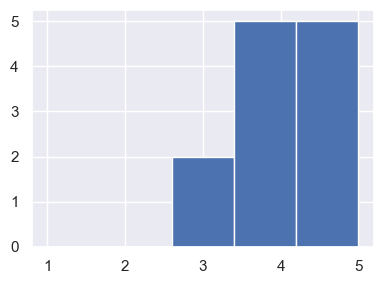

In [248]:
plt.figure(figsize=(4, 3))

plt.hist(survey.iloc[:, 6].values.tolist(), bins=5, range=(1, 5))
plt.tight_layout()

plt.show()

### 4.2.2 How relevant were the shown GUIs for your initial requirements on average?

In [249]:
survey.iloc[:,7].describe()

count    12.000000
mean      4.166667
std       0.717741
min       3.000000
25%       4.000000
50%       4.000000
75%       5.000000
max       5.000000
Name: How relevant were the shown GUIs for your initial requirements on average?, dtype: float64

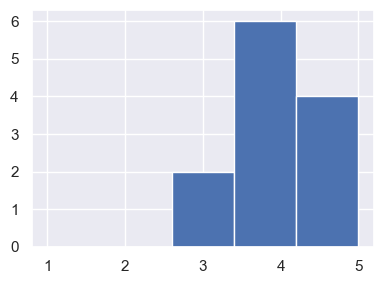

In [250]:
plt.figure(figsize=(4, 3)) 

plt.hist(survey.iloc[:, 7].values.tolist(), bins=5, range=(1, 5))
plt.tight_layout()

plt.show()

### 4.2.3 How relevant were the recommend GUI features on average?

In [251]:
survey.iloc[:,8].describe()

count    12.000000
mean      3.833333
std       0.937437
min       2.000000
25%       3.000000
50%       4.000000
75%       4.250000
max       5.000000
Name: How relevant were the recommend GUI features on average?, dtype: float64

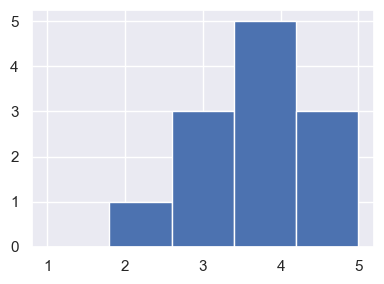

In [252]:
plt.figure(figsize=(4, 3))

plt.hist(survey.iloc[:, 8].values.tolist(), bins=5, range=(1, 5))
plt.tight_layout()

plt.show()

### 4.2.4 How relevant were the visualizations of GUI features on average?

In [253]:
survey.iloc[:,9].describe()

count    12.000000
mean      2.916667
std       0.514929
min       2.000000
25%       3.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: How relevant were the visualizations of GUI features on average?, dtype: float64

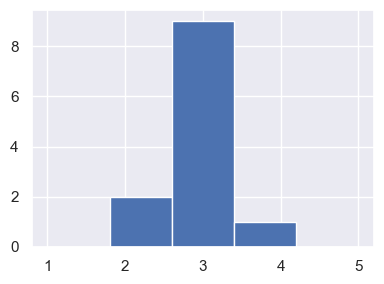

In [254]:
plt.figure(figsize=(4, 3))

plt.hist(survey.iloc[:, 9].values.tolist(), bins=5, range=(1, 5))
plt.tight_layout()

plt.show()

### 4.2.5 How much did the feature recommendations help you in adding relevant features that you did not think about initially?

In [255]:
survey.iloc[:,10].describe()

count    12.000000
mean      4.250000
std       0.965307
min       2.000000
25%       4.000000
50%       4.500000
75%       5.000000
max       5.000000
Name: How much did the feature recommendations help you in adding relevant features that you did not think about initially?, dtype: float64

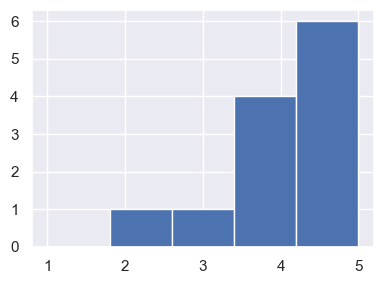

In [256]:
plt.figure(figsize=(4, 3))

plt.hist(survey.iloc[:, 10].values.tolist(), bins=5, range=(1, 5))
plt.tight_layout()

plt.show()

### 4.2.6 How much did the visualizations of the feature recommendations help you in better understanding the features?

In [257]:
survey.iloc[:,11].describe()

count    12.000000
mean      3.166667
std       1.267304
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: How much did the visualizations of the feature recommendations help you in better understanding the features?, dtype: float64

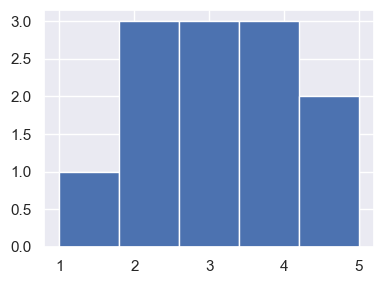

In [258]:
plt.figure(figsize=(4, 3))

plt.hist(survey.iloc[:, 11].values.tolist(), bins=5, range=(1, 5))
plt.tight_layout()

plt.show()

### 4.2.7 Summary

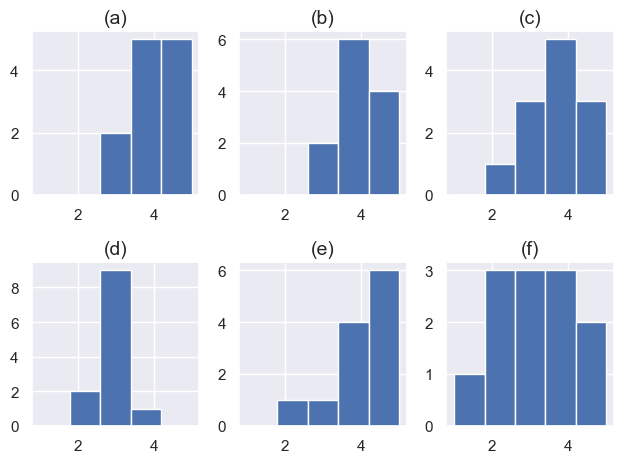

In [259]:
f,a = plt.subplots(2,3)
a = a.ravel()
titles = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for idx,ax in enumerate(a):
    ax.hist(survey.iloc[:,(6+idx)].values.tolist(), bins = 5, range=(1,5))
    ax.set_title(titles[idx], fontsize=14)
plt.tight_layout()

In [27]:
f.savefig(abs_path_data+"usability.pdf")

## 4.3 System Usability Scale

In [260]:
def compute_sus(data):
    sus = 0
    for i in range(0,10):
        if i%2 == 0: 
            sus += (data[i] - 1)
        else:
            sus += (5 - data[i])
    return sus * 2.5

In [261]:
sus = []
for index, row in survey.iterrows():
    scores = row.iloc[12:22].values.tolist()
    sus_score = compute_sus(scores)
    sus.append(sus_score)

In [262]:
np.mean(sus)

84.16666666666667